In [2]:
import pandas as pd
import dash
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

df_dejavnosti = pd.read_csv("data/podatki_po_dejavnostih.csv", delimiter=",", encoding="windows-1250")
df_odjemalci = pd.read_csv("data/podatki_vrsta_odjemalca.csv", delimiter=",", encoding="windows-1250")


In [3]:
df_odjemalci_backup = df_odjemalci.copy()


df = df_odjemalci_backup[::+3]
df = df[1:-1]

df = df.drop("VRSTA ODJEMALCA", axis=1)

obcine = {df["OBČINE"][i]:i for i in df.index}

vse_2020 = dict(df[df.columns[1:13]].sum(axis=1))
vse_2021 = dict(df[df.columns[13:25]].sum(axis=1))
vse_2022 = dict(df[df.columns[25:34]].sum(axis=1))

dict_porab = dict([(k,[vse_2020[k], vse_2021[k], vse_2022[k]]) for k in vse_2020])

koncni_dict = dict()

for k,v in obcine.items():
    koncni_dict[k] = dict_porab[v]


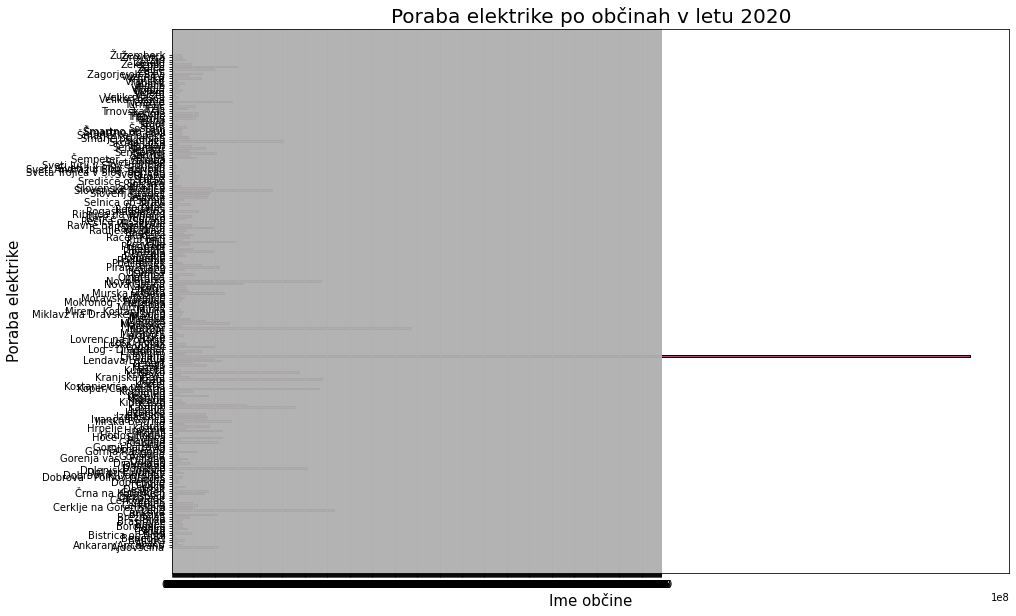

In [4]:
x = list(koncni_dict.keys())
y = list()

for value in koncni_dict.values():
    y.append(value[0])

plt.figure(figsize=(15,10))
plt.barh(x, y, color='#F72585', edgecolor='black')
plt.grid(axis='x')
plt.xticks(np.arange(0, 1000000000, step=1000000))
plt.title('Poraba elektrike po občinah v letu 2020', fontsize=20)
plt.xlabel('Ime občine', fontsize=15)
plt.ylabel('Poraba elektrike', fontsize=15)
plt.show()
